#**SDP**

Consider a system $\mathbf{\dot{x}} = \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{u}$ and a Lyapunov function $V = \mathbf{x}^\top\mathbf{S}\mathbf{x}$, $\mathbf{S} \succ 0$.
We need to find a state feedback controller of the form
\begin{equation}
\mathbf{u} = \mathbf{K}\mathbf{x}
\end{equation}
such that the closed-loop system namely
\begin{equation}
\begin{gathered}
\mathbf{\dot{x}} = \mathbf{(A+BK)}\mathbf{x}
\end{gathered}
\end{equation} is quadratically stable.

In [ ]:
import numpy as np
import cvxpy as cp

size_x = 3
size_u = 2

# A = np.array([[-2.264, 1.5279, -0.9707], [0.47, -1.1007, 0.3038], [-1.726, 1.585, -0.8657]])
# B = np.array([[-0.332, 0.4735], [-0.03225, -0.2292], [-0.23256, 0.415154]])

A = np.random.randn(size_x, size_x) - 1*np.eye(size_x)
B = 0.3*np.random.randn(size_x, size_u)

Q = cp.Variable((size_x, size_x), symmetric=True)
L = cp.Variable((size_u, size_x))

LMI = cp.bmat([[Q @ A.T + A @ Q + L.T @ B.T + B @ L]])

constraints = [Q >> 0.0001, LMI << -0.0001]
prob = cp.Problem(cp.Minimize(0), constraints=constraints)

result = prob.solve(verbose=False)

if result < 1:
    K = L.value @ np.linalg.pinv(Q.value)
    print("State feedback controller gain(K):")
    print(K)
else:
    print("no solution")

State feedback controller gain(K):
[[-36.5811282   23.94459714  14.01850969]
 [-27.78868362  19.32681396   7.98447725]]


In [ ]:
Acl = A + B @ K
e1, _ = np.linalg.eig(Acl)
print(e1)

[-7.04211475 -0.64867165 -2.66612442]


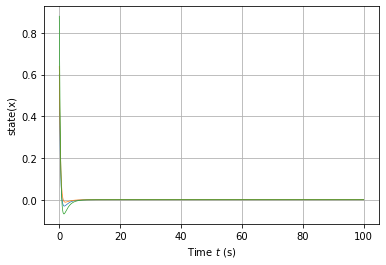

In [ ]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

t0 = 0 # Initial time
tf = 100 # Final time
N = 2E3 # Numbers of points in time span
t = np.linspace(t0, tf, int(N)) # Create time span

x_0 = np.random.rand(size_x,)

def StateSpace(q, t, A, B, K):
    x = q
    u = K @ x
    ddx = A @ x + B @ u
    return ddx

x_sol = odeint(StateSpace, x_0, t, args=(A, B, K))
plt.plot(t, x_sol, linewidth=0.7)
plt.ylabel(r'state(x)')
plt.grid(True)
plt.xlabel(r'Time $t$ (s)')
plt.show()

#**Robustness**
Let us consider the uncertain time-invariant linear system
\begin{equation*}
\dot{x} = (A+\Delta A)x + (B+\Delta B)u
\end{equation*}
with
\begin{equation*}
(\Delta A \quad \Delta B) = F \Delta (E_1 \quad E_2),
\end{equation*}
where $u \in \mathbb{R}^m$ is the control input, and F, E1, and E2 are weighting matrix-valued functions of suitable dimensions. \\
The uncertain system can be transformed into the LFT form
\begin{equation}
\begin{gathered}
\dot{x} = Ax+F\omega+Bu,\\
z=E_1 x +E_2 u,\\
\omega = \Delta z.
\end{gathered}
\end{equation}

We need to find a state feedback controller of the form
\begin{equation}
u = Kx
\end{equation}
such that  that the closed-loop system namely
\begin{equation}
\begin{gathered}
\dot{x} = (A+BK)x+F\omega,\\
z=(E_1 +E_2 K) x,\\
\omega = \Delta z.
\end{gathered}
\end{equation}
is quadratically stable.

**Final LMI**
\begin{equation}
\begin{gathered}
\begin{pmatrix}
    QA^T+AQ +L^TB^T+BL & F & Q E_1^T + L^T E_2^T\\
    F^T & - I & 0\\
    E_1 Q + E_2 L & 0 & -I
\end{pmatrix}
< 0
\end{gathered}
\end{equation}
The controller that solves this problem is $K=LQ^{-1}$

In [ ]:
import numpy as np
import cvxpy as cp

np.random.seed(seed=30)

size_x = 3
size_u = 2

A = np.random.randn(size_x, size_x) - 1*np.eye(size_x)
B = 0.3*np.random.randn(size_x, size_u)
F = 0.3*np.random.randn(size_x, size_u)
E1 = 0.3*np.random.randn(size_u, size_x)
E2 = 0.3*np.random.randn(size_u, size_u)

Q = cp.Variable((size_x, size_x), symmetric=True)
L = cp.Variable((size_u, size_x))

LMI = cp.bmat([
        [Q@A.T + L.T @ B.T + A@Q +B@L, F, Q@E1.T + L.T@E2.T],
        [F.T, -np.eye(size_u), np.zeros((size_u,size_u))],
        [E1@Q + E2@L, np.zeros((size_u,size_u)), -np.eye(size_u)]
          ])

constraints = [Q >> 0.0001, LMI << 0]
prob = cp.Problem(cp.Minimize(0), constraints=constraints)

result = prob.solve()
if result < 1:
    K = L.value @ np.linalg.pinv(Q.value)
    print("State feedback controller gain (K):")
    print(K)
else:
    print("no solution")

In [ ]:
# Here we randomize different uncertainties in the system and check the stability
stable_systems = 0
max_eig = []

# Interval of Deltas values
delta_min, delta_max = -1, 1
numDelta = 1000

for i in range(numDelta):
    Delta = np.diag((delta_max - delta_min)*np.random.rand(size_u, ) + delta_min)
    # Checking eigenvalues to prove stability
    Acl = A + B @ K + F @ Delta @ (E1 + E2 @ K)

    e1, _ = np.linalg.eig(Acl)
    max_eig.append(np.max(e1))

    eigNeg = len(list(filter(lambda x: x.real < 0, e1)))
    if eigNeg == len(e1):
        stable_systems += 1

print("max eig")
print(np.max(max_eig))
print("Percentage of stable systems:", 100*stable_systems/numDelta)